In [1]:
%pip install requests
%pip install pandas
%pip install networkx
import requests
import json
import os
import time
import networkx as nx
import pdb
import matplotlib.pyplot as plt
import pickle
import textwrap

from google.colab import files
from google.colab import userdata

In [2]:
S2_API_KEY = userdata.get('APIKEY')

In [13]:
authorsNames = []
articlesNames = []
# Used to prevent getting authors from another field with the same name
Field = "Computer Science"

Upload custom author list

In [86]:
uploaded = files.upload()
name = list(uploaded.keys())[0]

with open(f'{name}') as f:
    authorsNames = f.read().splitlines()

Saving articles.txt to articles.txt


Upload custom aticle list

In [14]:
uploaded = files.upload()
name = list(uploaded.keys())[0]

with open(f'{name}') as f:
    articlesNames = f.read().splitlines()

Saving articles.txt to articles (1).txt


In [15]:
authors = []
qualityWorks = []
references = []

Getting authors Id's.

WARNING: There's no guarantee that the fetched authors will be the desired ones (the code prioritize the most famous ones in the field that match the name), if some data looks strange, checking on the Semantic Scholar website is recommended.

In [16]:
for author in authorsNames:
  first,midle,*last = author.split(' ')
  last = last if last else " "

  # Don't stop until get the authors, ignoring failures
  while True:
    try:
      time.sleep(.3)
      rsp = requests.get(f"https://api.semanticscholar.org/graph/v1/author/search?query={first}+{midle}+{last}",
                     headers={'X-API-KEY': S2_API_KEY},
                     params={'fields': 'authorId,name,citationCount,papers,papers.fieldsOfStudy','limit': '50'})

      rsp.raise_for_status()
      break

    except requests.exceptions.RequestException:
      pass


  # add the first author on the search results
  data = rsp.json()['data']
  data = sorted(data, key=lambda x:x['citationCount'])
  data.reverse()

  # get correct author by field of study
  i = 0

  if not data:
    break

  while True:

    if data and data[i] and data[i]['papers']:
      # Try to find a paper that satisfies the conditions
      iteration_count, found_paper = next(
          (
          (index, paper)
          for index, paper in enumerate(data[i]['papers'])
          if (paper['fieldsOfStudy'] is not None) and (Field in paper['fieldsOfStudy'])
          ),
          (None, None)
      )

      # Check if a valid paper was found or if the maximum iterations are reached
      if found_paper is not None and iteration_count < 10:
        #print(f"Iteration {iteration_count}: {found_paper=}")
        print(f"{data[i]['name']}\t citations: {data[i]['citationCount']}  papers: {len(data[i]['papers'])}")

        del data[i]['papers']
        authors.append(data[i])
        break

    # Move to the next index
    if i < len(data)-1:
      i += 1
    # If failed to find go to the next on the list
    else:
      break



Getting the articles

In [17]:
for article in articlesNames:
  try:
    time.sleep(0.3)
    rsp = requests.get(f"https://api.semanticscholar.org/graph/v1/paper/autocomplete?query={article}",
                    headers={'X-API-KEY': S2_API_KEY},
                    params={'limit': '5'})

    rsp.raise_for_status()
    if rsp.json()["matches"]:

      item = rsp.json()['matches'][0]

      rsp = requests.get(f"https://api.semanticscholar.org/graph/v1/paper/{item['id']}",
                    headers={'X-API-KEY': S2_API_KEY},
                    params={'fields': 'title,paperId,fieldsOfStudy,references,references.title,references.citationCount,references.influentialCitationCount,citationCount,influentialCitationCount'})
      rsp.raise_for_status()

      paper = rsp.json()

      if paper['paperId'] is not None:
        # add all papers cited by the paper
        ref = []
        for x in paper['references']:
          if x['paperId'] is not None:
            x['quality'] = False
            ref.append(x)

        references.append(ref)

        # add paper
        del paper['references']
        paper['quality'] = True
        qualityWorks.append(paper)

    else:
      print(f"Could not find {article}")

  except requests.exceptions.RequestException:
    pass

Getting author's publications and references

In [18]:
for author in authors:
  # Get a list of all authors publications and their respectives references

  while True:
    try:
      time.sleep(0.3)
      rsp = requests.get(f"https://api.semanticscholar.org/graph/v1/author/{author['authorId']}/papers",
                     headers={'X-API-KEY': S2_API_KEY},
                     params={'fields': 'title,paperId,fieldsOfStudy,references,references.title,references.citationCount,references.influentialCitationCount,citationCount,influentialCitationCount',
                             'limit': 900})
                     # reference.citationCount, etc

      rsp.raise_for_status()
      break

    except requests.exceptions.RequestException:
      pass

  data = rsp.json()['data']

  for paper in data:
    if paper['paperId'] is not None:
      # add all papers cited by the paper
      ref = []
      for x in paper['references']:
        if x['paperId'] is not None:
          x['quality'] = False
          ref.append(x)

      #print(ref)
      references.append(ref)

      # add paper
      del paper['references']
      paper['quality'] = True
      qualityWorks.append(paper)



In [19]:
for paper in qualityWorks:
  if paper['fieldsOfStudy']:
    if Field not in paper['fieldsOfStudy']:
      #print(f"Deleted not in the field {paper['title']}")
      del paper

We now have a list filled with papers and another list filed with a list of that paper references. Thus, basically a adjacency list.

As for now, this list only contains the most important work (the writings of handpicked authors) that we will consider to be of high quality.

Adding depth means to add the references's references into our graph.

In [20]:
nodes = qualityWorks.copy()
edges = references.copy()
qualityIds = [x['paperId'] for x in qualityWorks]

In [21]:
# add one more depth into the search
def addDepth():
  lenght = len(edges)

  for i in range(lenght):
    print(f"{i} / {lenght}")
    # if has reference
    if edges[i]:
      for paper in edges[i]:
        end = False

        # add reference paper into the node list
        if paper not in nodes:
          nodes.append(paper)
        # if is already prossed, go to the next
        else:
          continue

        # get paper references
        while True:
          try:

            time.sleep(0.1)
            rsp = requests.get(f"https://api.semanticscholar.org/graph/v1/paper/{paper['paperId']}/references",
                          headers={'X-API-KEY': S2_API_KEY},
                          params={'fields': 'title,fieldsOfStudy,citationCount,influentialCitationCount'})
            rsp.raise_for_status()
            break

          except requests.exceptions.HTTPError as err:
            if rsp.status_code == 404:
              end = True

          except requests.exceptions.RequestException as e:
            print(e)
            pass

        if end:
          break

        data = rsp.json()['data']
        #print(paper['title'],len(data))

        # add the paper's references as his edges
        ref = []
        for x in data:
          if x['citedPaper']['paperId'] is not None and x['citedPaper']['fieldsOfStudy']:
            if Field in x['citedPaper']['fieldsOfStudy']:
              if x['citedPaper']['paperId'] in qualityIds:
                x['citedPaper']['quality'] = True
              else:
                x['citedPaper']['quality'] = False

              ref.append(x['citedPaper'])

        edges.append(ref)

In [22]:
for i in range(2):
  addDepth()

0 / 17
1 / 17
2 / 17
3 / 17
4 / 17
5 / 17
6 / 17
7 / 17
8 / 17
9 / 17
10 / 17
11 / 17
12 / 17
13 / 17
14 / 17
15 / 17
16 / 17
0 / 204
1 / 204
2 / 204
3 / 204
4 / 204
5 / 204
6 / 204
7 / 204
8 / 204
9 / 204
10 / 204
11 / 204
12 / 204
13 / 204
14 / 204
15 / 204
16 / 204
17 / 204
18 / 204
19 / 204
20 / 204
21 / 204
22 / 204
23 / 204
24 / 204
25 / 204
26 / 204
27 / 204
28 / 204
29 / 204
30 / 204
31 / 204
32 / 204
33 / 204
34 / 204
35 / 204
36 / 204
37 / 204
38 / 204
39 / 204
40 / 204
41 / 204
42 / 204
43 / 204
44 / 204
45 / 204
46 / 204
47 / 204
48 / 204
49 / 204
50 / 204
51 / 204
52 / 204
53 / 204
54 / 204
55 / 204
56 / 204
57 / 204
58 / 204
59 / 204
60 / 204
61 / 204
62 / 204
63 / 204
64 / 204
65 / 204
66 / 204
67 / 204
68 / 204
69 / 204
70 / 204
71 / 204
72 / 204
73 / 204
74 / 204
75 / 204
76 / 204
77 / 204
78 / 204
79 / 204
80 / 204
81 / 204
82 / 204
83 / 204
84 / 204
85 / 204
86 / 204
87 / 204
88 / 204
89 / 204
90 / 204
91 / 204
92 / 204
93 / 204
94 / 204
95 / 204
96 / 204
97 / 204
98

In [23]:
print(len(nodes))
print(len(edges))

1927
1927


Create or upload(next cell) a graph

In [24]:
G = nx.DiGraph()

atributes = ['citationCount','influentialCitationCount','quality','title']

for i,l in enumerate(edges):
  for edge in l:

    if edge['paperId'] in qualityIds:
      edge['quality'] = True

    # Calculate the edge weight
    if nodes[i]['quality'] == True:
      influence = 0
    else:
      # Reversing the weights so that it has a inverse effect
      if nodes[i]['influentialCitationCount'] and nodes[i]['citationCount']:
        influence = 1/(nodes[i]['citationCount'] + 5*nodes[i]['influentialCitationCount'])
      else:
        if nodes[i]['citationCount']:
          influence = 1/(nodes[i]['citationCount'])
        else:
          influence = 0.5

    ne = {'influence': influence}

    # Add references as edges and nodes, as needed
    if edge not in nodes:
      nn = {key: edge[key] for key in atributes}

      if edge['paperId'] in qualityIds:
        nn['quality'] = True

      G.add_nodes_from([(edge['paperId'],nn)])
      G.add_edges_from([(edge['paperId'],nodes[i]['paperId'],ne)])

    else:
      G.add_edges_from([(edge['paperId'],nodes[i]['paperId'],ne)])

# Add the rest of nodes
for node in nodes:
  ne = {key: node[key] for key in atributes}
  G.add_nodes_from([(node['paperId'],ne)])

with open('literature.gpickle', 'wb') as f:
  pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

files.download("literature.gpickle")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload a graph

In [ ]:
uploaded = files.upload()
name = list(uploaded.keys())[0]

with open(name, 'rb') as f:
    G = pickle.load(f)

Paper ranking

In [25]:
ranking = []

for node,data in G.nodes(data=True):
  # skip calculation on quality papers
  if data['quality']:
    continue

  sum = 0
  counter = 0
  for work in qualityWorks:

    # calculate distance using dijkstra
    try:
      sum = sum + nx.shortest_path_length(G, source=node, target=work['paperId'], weight='influence')
    # base number is lower when there's no path
    except nx.NetworkXNoPath:
      counter = counter + 1

  if sum == 0:
    avg = 0
  else:
    avg = (len(qualityWorks) - counter)/sum

  if data['influentialCitationCount'] and data['citationCount']:
    score = data['citationCount'] + 5*data['influentialCitationCount']
  else:
    if data['citationCount']:
      score = data['citationCount']
    else:
      score = 1

  # avg will be a small value as the weights are reversed
  score = score * avg
  ranking.append({'score':score,'title':data['title'],'id':node})

In [26]:
ranking = sorted(ranking, key=lambda x:x['score'])
ranking.reverse()

top = ranking[:20]

topIds = [x['id'] for x in top]

subgraph = G.subgraph(qualityIds + topIds)

# quality -> red
# influent (top 10) -> orange
# the rest -> blue
node_colors = ['orange' if node in topIds else 'red' if node in qualityIds else 'blue' for node,data in subgraph.nodes(data=True)]

In [28]:
for paper in top:
  print(paper['title'])

ImageNet classification with deep convolutional neural networks
Very Deep Convolutional Networks for Large-Scale Image Recognition
Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks
Learning Multiple Layers of Features from Tiny Images
Microsoft COCO: Common Objects in Context
Going deeper with convolutions
ImageNet Large Scale Visual Recognition Challenge
Fully convolutional networks for semantic segmentation
Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
Random Forests
Rich Feature Hierarchies for Accurate Object Detection and Semantic Segmentation
Fast R-CNN
Auto-Encoding Variational Bayes
ImageNet: A large-scale hierarchical image database
The Pascal Visual Object Classes (VOC) Challenge
Caffe: Convolutional Architecture for Fast Feature Embedding
Rectified Linear Units Improve Restricted Boltzmann Machines
Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
Understandi

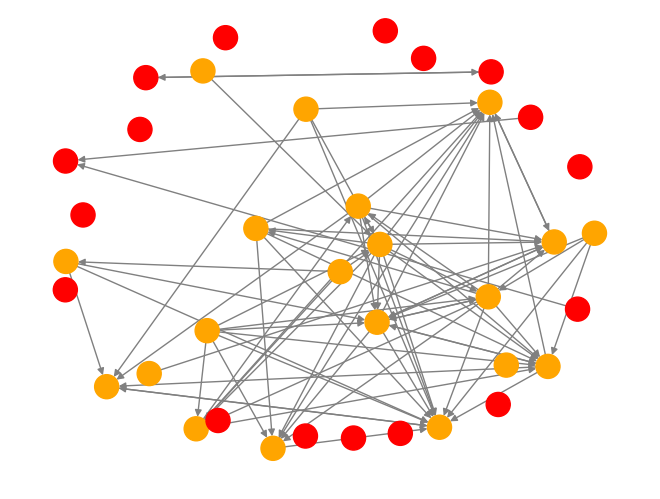

In [29]:
# Draw the graph
pos = nx.spring_layout(subgraph, k=1.7)
nx.draw(subgraph, pos, node_color=node_colors, font_color="black", font_weight="bold", edge_color="gray", linewidths=1)

#node_labels = {node: '\n'.join(textwrap.wrap(data['title'], width=26)) for node,data in subgraph.nodes(data=True)}
#nx.draw_networkx_labels(G, pos, labels=node_labels,font_size=6, verticalalignment="bottom")

plt.show()